In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import numpy as np
import pandas as pd

from csrank.callbacks import DebugOutput
from csrank.constants import OBJECT_RANKING
from csrank.fate_ranking import FATEObjectRanker
from csrank.util import rename_file_if_exist, configure_logging_numpy_keras, get_tensor_value, create_dir_recursively, tensorify,scores_to_rankings
from keras.utils import plot_model
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from csrank.losses import *
from csrank.metrics import *
from csrank.dataset_reader import SyntheticDatasetGenerator
from sklearn.utils import check_random_state
from collections import OrderedDict

Using TensorFlow backend.


In [2]:
ranking_metrics = OrderedDict(
    {'KendallsTau': kendalls_tau_for_scores, 'SpearmanCorrelation': spearman_correlation_for_scores,
     'ZeroOneRankLoss': zero_one_rank_loss_for_scores,
     'ZeroOneRankLossTies': zero_one_rank_loss_for_scores_ties, "ZeroOneAccuracy": zero_one_accuracy_for_scores})
ERROR_OUTPUT_STRING = 'Out of sample error %s : %0.4f'

In [3]:
SUB_FOLDER = "gr_vis"
MODEL = "aModel"
log_path = os.path.join(os.getcwd(), SUB_FOLDER, "gr.log")

In [4]:
def generate_medoid_dataset(n_objects = 3, n_features = 2, random_state=42, **kwargs):
    n_features = n_features
    n_train_instances = 100
    n_test_instances = 6
    n_objects = n_objects
    random_state = check_random_state(random_state)
    params = {'n_train_instances': n_train_instances, 'n_test_instances': n_test_instances, 'n_features': n_features,
              'n_objects': n_objects,
              'random_state': random_state}
    or_generator = SyntheticDatasetGenerator(**params)
    return or_generator.get_single_train_test_split() 

In [5]:
def get_evaluation_result(gor, X_train, Y_train, X_test, Y_test):
    gor.fit(X_train, Y_train, log_callbacks=[DebugOutput()], epochs=epochs)
    y_pred_scores = gor.predict_scores(X_test, batch_size=X_test.shape[0])
    dict1 = {}

    for name, evaluation_metric in ranking_metrics.items():
        metric_loss = get_tensor_value(evaluation_metric(Y_test, y_pred_scores))
        logger.info(ERROR_OUTPUT_STRING % (name, np.mean(metric_loss)))
        dict1[name] = metric_loss
    return dict1

In [6]:
log_path = os.path.join(os.getcwd(), SUB_FOLDER, "gr.log")
log_path = rename_file_if_exist(log_path)
random_state = np.random.RandomState(seed=42)


logger = configure_logging_numpy_keras(seed=random_state.randint(2 ** 32), log_path=log_path)
logger.info(log_path)

X_train, Y_train, X_test, Y_test = generate_medoid_dataset(n_objects=5)
n_instances, n_objects, n_features = X_train.shape

epochs = 5
params = {"n_objects": n_objects, "n_object_features": n_features, "use_early_stopping": True, "use_lr_annealer": True}
logger.info(params)
n_hidden_joint_units = 5
n_hidden_set_units = 7
logger.info("n_hidden_joint_units {} and  n_hidden_set_units {}".format(n_hidden_joint_units, n_hidden_set_units))
logger.info("############################# With set layers ##############################")
gor = GeneralObjectRanker(n_hidden_joint_layers=1, n_hidden_joint_units=n_hidden_joint_units, n_hidden_set_layers=1, n_hidden_set_units=n_hidden_set_units, **params)
result = get_evaluation_result(gor, X_train, Y_train, X_test, Y_test)
result[MODEL] = "5SetLayersDefaultParams"

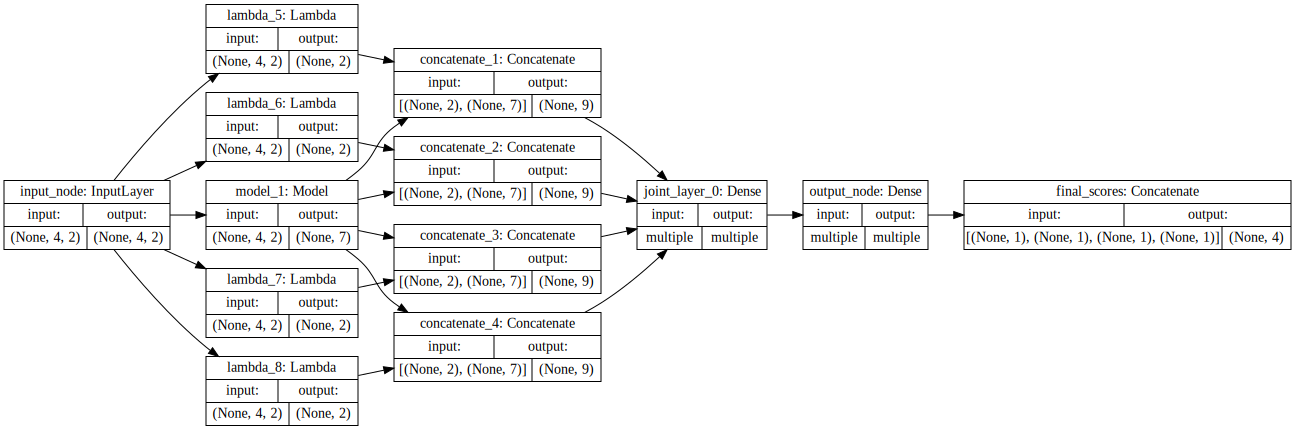

In [12]:
SVG(model_to_dot(gor.model, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

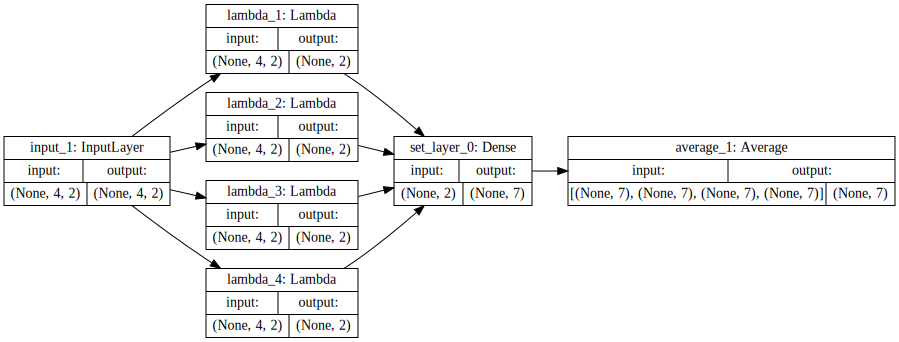

In [8]:
SVG(model_to_dot(gor.set_layer.cached_models[n_objects], show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

In [ ]:
SVG(model_to_dot(gor.model, show_shapes=True,
                 rankdir='LR').create(prog='dot', format='svg'))

In [ ]:
SVG(model_to_dot(gor.scoring_model, show_shapes=True,
                 rankdir='LR').create(prog='dot', format='svg'))

In [ ]:
model_path = os.path.join(os.getcwd(), SUB_FOLDER, "completeModel.png")
plot_model(plot_model(gor.model,to_file=model_path,show_shapes=True,
                 rankdir='LR'))


In [ ]:
model_path = os.path.join(os.getcwd(), SUB_FOLDER, "setModel.png")
plot_model(plot_model(gor.set_layer.model,to_file=model_path,show_shapes=True,
                 rankdir='LR'))